In [1]:
import sys
sys.path.append('./data_prep')
sys.path.append('./models')

In [2]:
from clustering_models import service_type_sep, make_scaled_df, num_of_components, feature_explained_variance,\
                            scree_plot, elbow_method, k_distance_plot, clustering_model, cluster_evaluation, comparison_of_scores_kmeans,\
                            cluster_visualization, cluster_separation, clusters_center, compare_columns, cluster_center_visualize, visualize_service_type, comparison_of_scores_dbscan
from data_preparation import get_data, get_cluster_df, get_regression_df
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50) 

# font_name = fm.FontProperties(fname="/Users/leeseohyun/Library/Fonts/AppleGothic.ttf").get_name()
# mpl.rc('font', family=font_name)
plt.rcParams["axes.unicode_minus"] = False

In [3]:
''' 
# 전처리된 데이터 불러오기 

cnx = pymysql.connect(user='mt-1', password='1111', host='ec2-15-152-249-56.ap-northeast-3.compute.amazonaws.com', database='zigbang_project')
query = 'SELECT * FROM zigbang_project.zb_final_cluster;'
df = pd.read_sql(query, cnx)
cnx.close()
'''

# 군집분석에 맞는 전처리된 데이터 불러오기 
clustering_df = get_cluster_df()

clustering_df.shape

(34229, 47)

<Axes: >

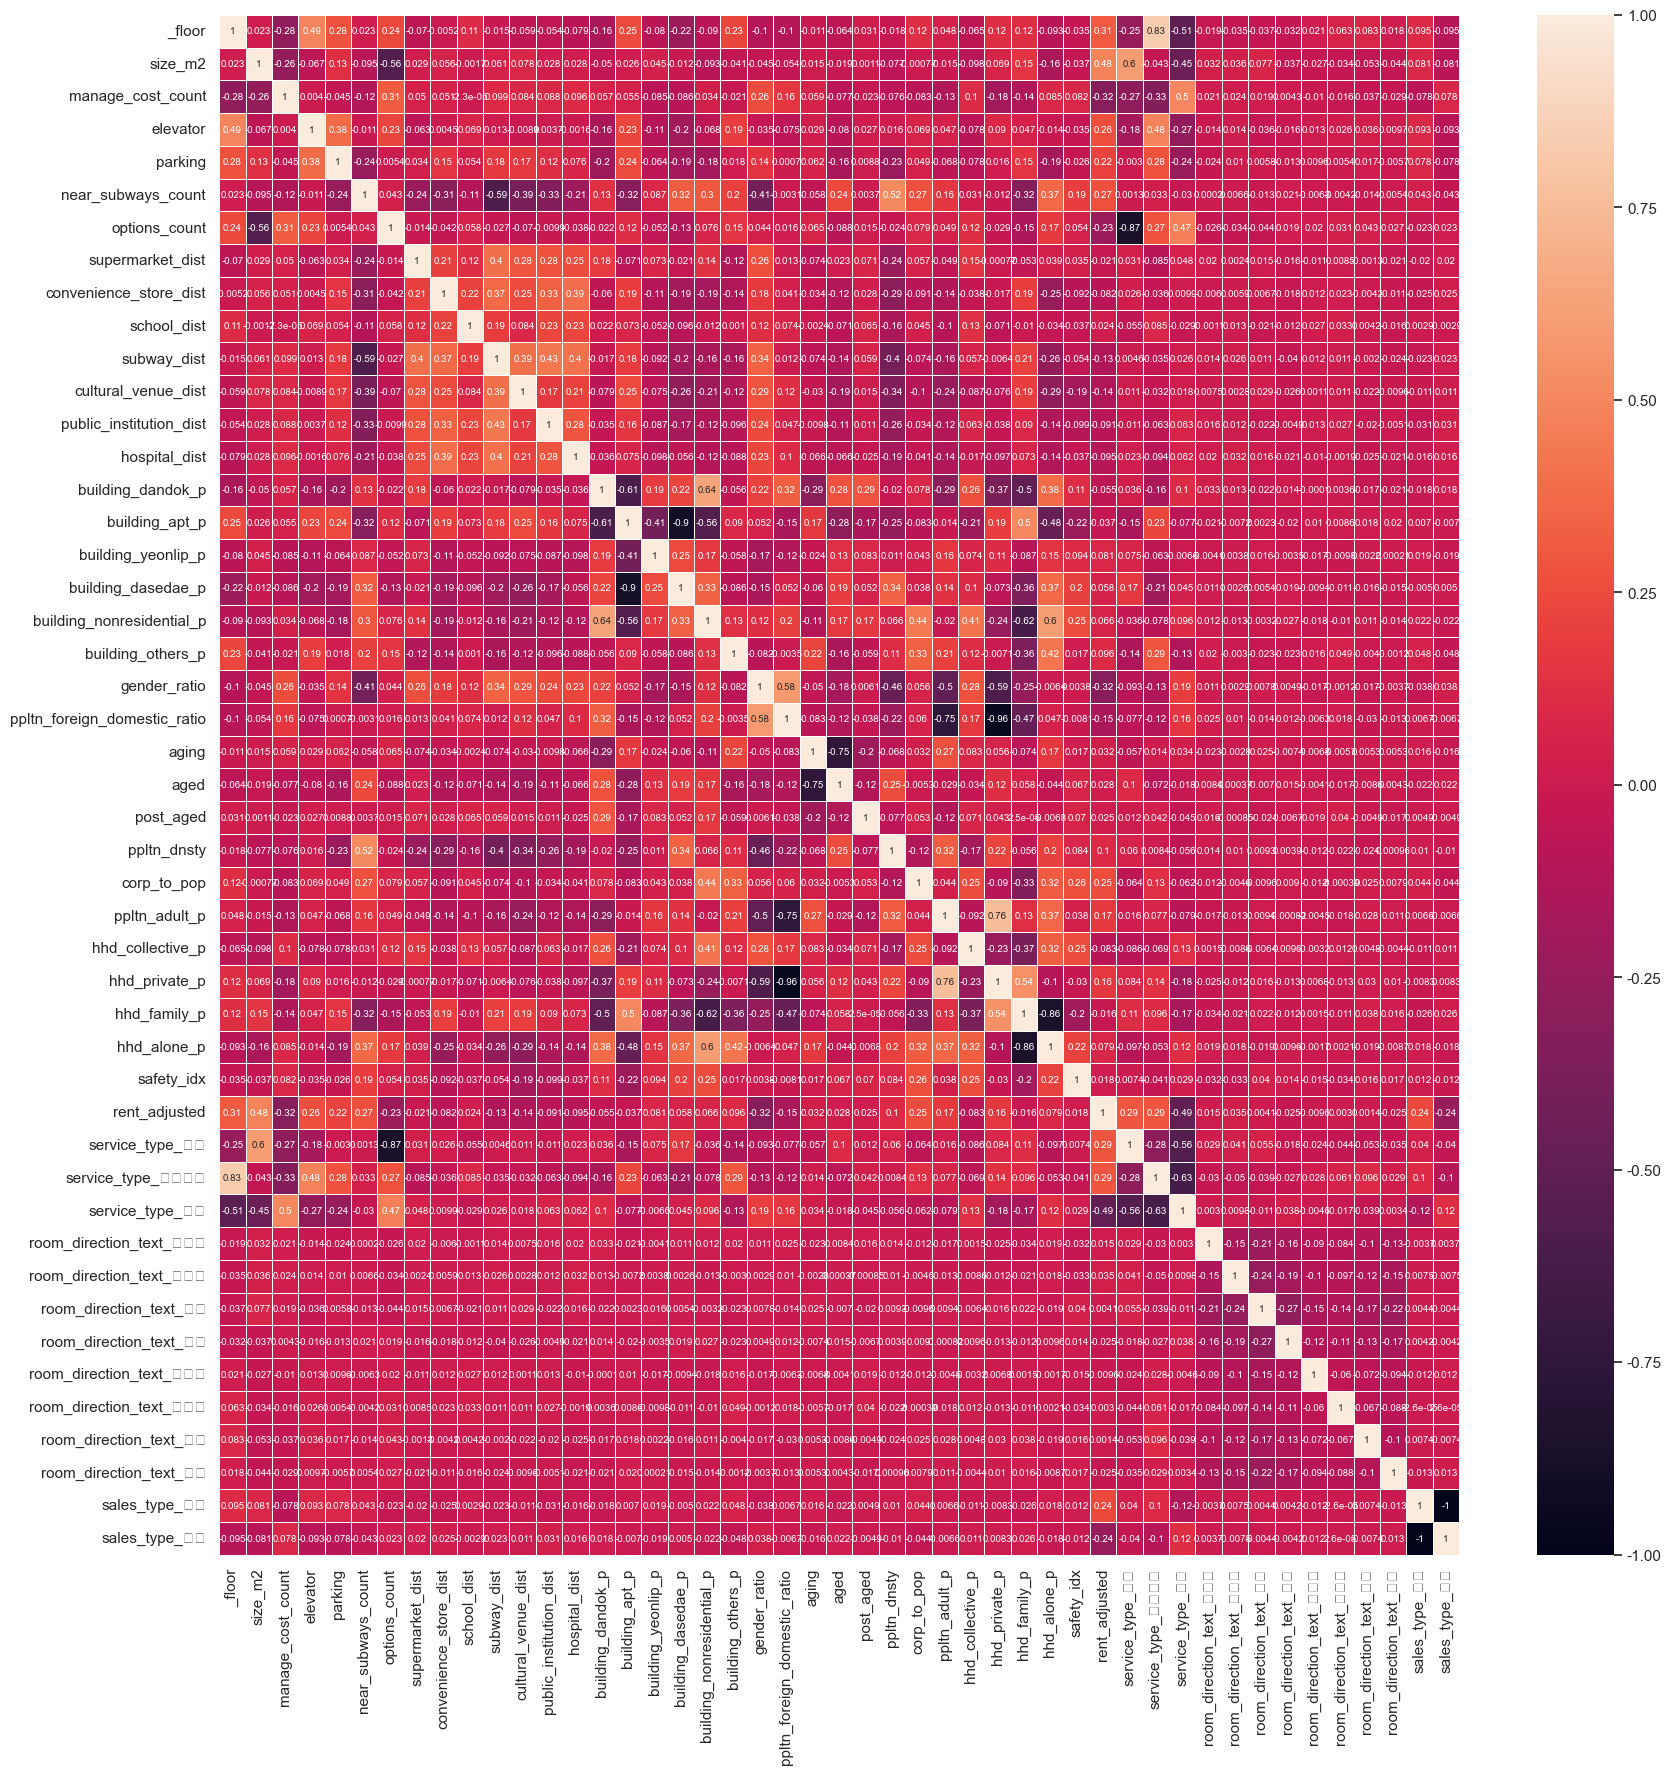

In [5]:
sns.set(rc={"figure.figsize": (20, 20)})
sns.heatmap(data=clustering_df.corr(), annot=True, linewidths=0.5, annot_kws={"size": 7})

In [4]:
# heatmap 뜯어보기 (abs(corr)>=0.5)
# 0.5 이상이면 무조건 드랍 하는게 아니라 도메인 지식 활용해서 고려하기 

# building_dandok_p & building_nonresidential_p 상관도 높음 
clustering_df = clustering_df.drop(columns=['building_nonresidential_p'])

# _floor & service_type_오피스텔 -> 상관도 높지만 둘중에 하나 없에는 건 아님 

# hhd_family_p: 많은 변수들이랑 음의 상관계수가 높았다. 당연히 음의 상관계수 높음 (-0.9) -> 제거 
clustering_df = clustering_df.drop(columns=['hhd_family_p'])

# hhd_private_p: 일반가구비율 해석에 크게 의미 없는 변수이고 ppltn_adult_p 와 양의 상관관계가 너무 높다
# adult & private proportion 비슷한 특성이라 봐도 되겠다 
clustering_df = clustering_df.drop(columns=['hhd_private_p'])

# aging, aged, post_aged: 고령사회(aged)이상이면 1, 이하면 0 -> 새로운 피쳐 aging_society
# aged & post_aged: 노령화지수 비교적으로 높아서 1로 판단 
clustering_df['aging_society'] = np.where((clustering_df['aged'] == 1) | (clustering_df['post_aged'] == 1), 1, 0)
clustering_df = clustering_df.drop(columns=['aging', 'aged', 'post_aged'])

clustering_df.shape 


(34229, 42)

## 데이터 스케일링 
- 원핫인코딩 & 0/1값만 있는 (이진) 컬럼들을 제외한 피쳐들 스케일링 필요 
- 스케일링 필요한 피쳐 (29/47) 

In [5]:
non_binary_columns = [col for col in clustering_df.columns if set(clustering_df[col].unique()) not in [{0, 1}, {0}, {1}]]
non_binary_df = clustering_df[non_binary_columns]

In [6]:
print(non_binary_df.columns)
print(non_binary_df.shape)

Index(['_floor', 'size_m2', 'manage_cost_count', 'near_subways_count',
       'options_count', 'supermarket_dist', 'convenience_store_dist',
       'school_dist', 'subway_dist', 'cultural_venue_dist',
       'public_institution_dist', 'hospital_dist', 'building_dandok_p',
       'building_apt_p', 'building_yeonlip_p', 'building_dasedae_p',
       'building_others_p', 'gender_ratio', 'ppltn_foreign_domestic_ratio',
       'ppltn_dnsty', 'corp_to_pop', 'ppltn_adult_p', 'hhd_collective_p',
       'hhd_alone_p', 'safety_idx', 'rent_adjusted'],
      dtype='object')
(34229, 26)


In [8]:
non_binary_df.describe()

_floor       size_m2  manage_cost_count  near_subways_count  \
count  34229.000000  34229.000000       34229.000000        34229.000000   
mean       6.219521     30.060105           1.544860            2.475679   
std        6.649505     15.040351           1.368398            1.544129   
min        1.000000      2.780000           0.000000            0.000000   
25%        2.000000     19.830000           0.000000            1.000000   
50%        3.000000     26.020000           2.000000            3.000000   
75%        8.000000     33.750000           3.000000            4.000000   
max       51.000000    280.930000           5.000000            7.000000   

       options_count  supermarket_dist  convenience_store_dist   school_dist  \
count   34229.000000      34229.000000            34229.000000  34229.000000   
mean        5.829443       1302.414035              128.723480    497.078355   
std         3.393104       1023.938633              100.912938    294.846767   
min         0.000000         10.000000                0.000000      8.000000   
25%         5.000000        656.000000               61.000000    305.000000   
50%         7.000000       1075.000000               98.000000    474.000000   
75%         8.000000       1660.000000              164.000000    641.000000   
max        12.000000      14268.000000             1639.000000   4037.000000   

        subway_dist  cultural_venue_dist  public_institution_dist  \
count  34229.000000          34229.00000             34229.000000   
mean     917.716089           3317.06512               582.044845   
std     1067.130791           3369.10923               415.186602   
min        5.000000             24.00000                 4.000000   
25%      374.000000           1178.00000               333.000000   
50%      583.000000           2191.00000               522.000000   
75%      996.000000           3957.00000               734.000000   
max    17040.000000          27603.00000              4278.000000   

       hospital_dist  building_dandok_p  building_apt_p  building_yeonlip_p  \
count   34229.000000       34229.000000    34229.000000        34229.000000   
mean      551.670484           0.125337        0.545291            0.037756   
std       380.691605           0.110506        0.286312            0.040762   
min         7.000000           0.000000        0.000000            0.000000   
25%       314.000000           0.042000        0.300000            0.009000   
50%       502.000000           0.099000        0.554000            0.028000   
75%       706.000000           0.183000        0.800000            0.054000   
max      4706.000000           0.931000        1.000000            0.645000   

       building_dasedae_p  building_others_p  gender_ratio  \
count        34229.000000       34229.000000  34229.000000   
mean             0.278647           0.168113      1.020719   
std              0.218672           0.267020      0.133598   
min              0.000000           0.000000      0.623000   
25%              0.079000           0.029000      0.939000   
50%              0.248000           0.069000      0.988000   
75%              0.437000           0.207000      1.066000   
max              0.888000           2.826000      2.455000   

       ppltn_foreign_domestic_ratio   ppltn_dnsty   corp_to_pop  \
count                  34229.000000  34229.000000  34229.000000   
mean                       0.087385  15883.048111      0.162970   
std                        0.162153  10961.784613      0.240833   
min                        0.003000     91.600000      0.026000   
25%                        0.020000   6904.800000      0.078000   
50%                        0.036000  13829.800000      0.104000   
75%                        0.083000  23876.700000      0.160000   
max                        4.340000  49681.100000      5.672000   

       ppltn_adult_p  hhd_collective_p   hhd_alone_p    safety_idx  \
count   34229.000000      34229.000000  

### 분포 확인 & 정규성 검정 
- 분포 확인: 대부분 오른쪽 꼬리가 아주 길다 
- D'Agostino & Pearson's Test: 왜도(skew) / 첨도(kurtosis)를 결합하여 종합적인 정규성 검정을 실행했으나 정규분포를 따르는 변수가 아예 없다. 

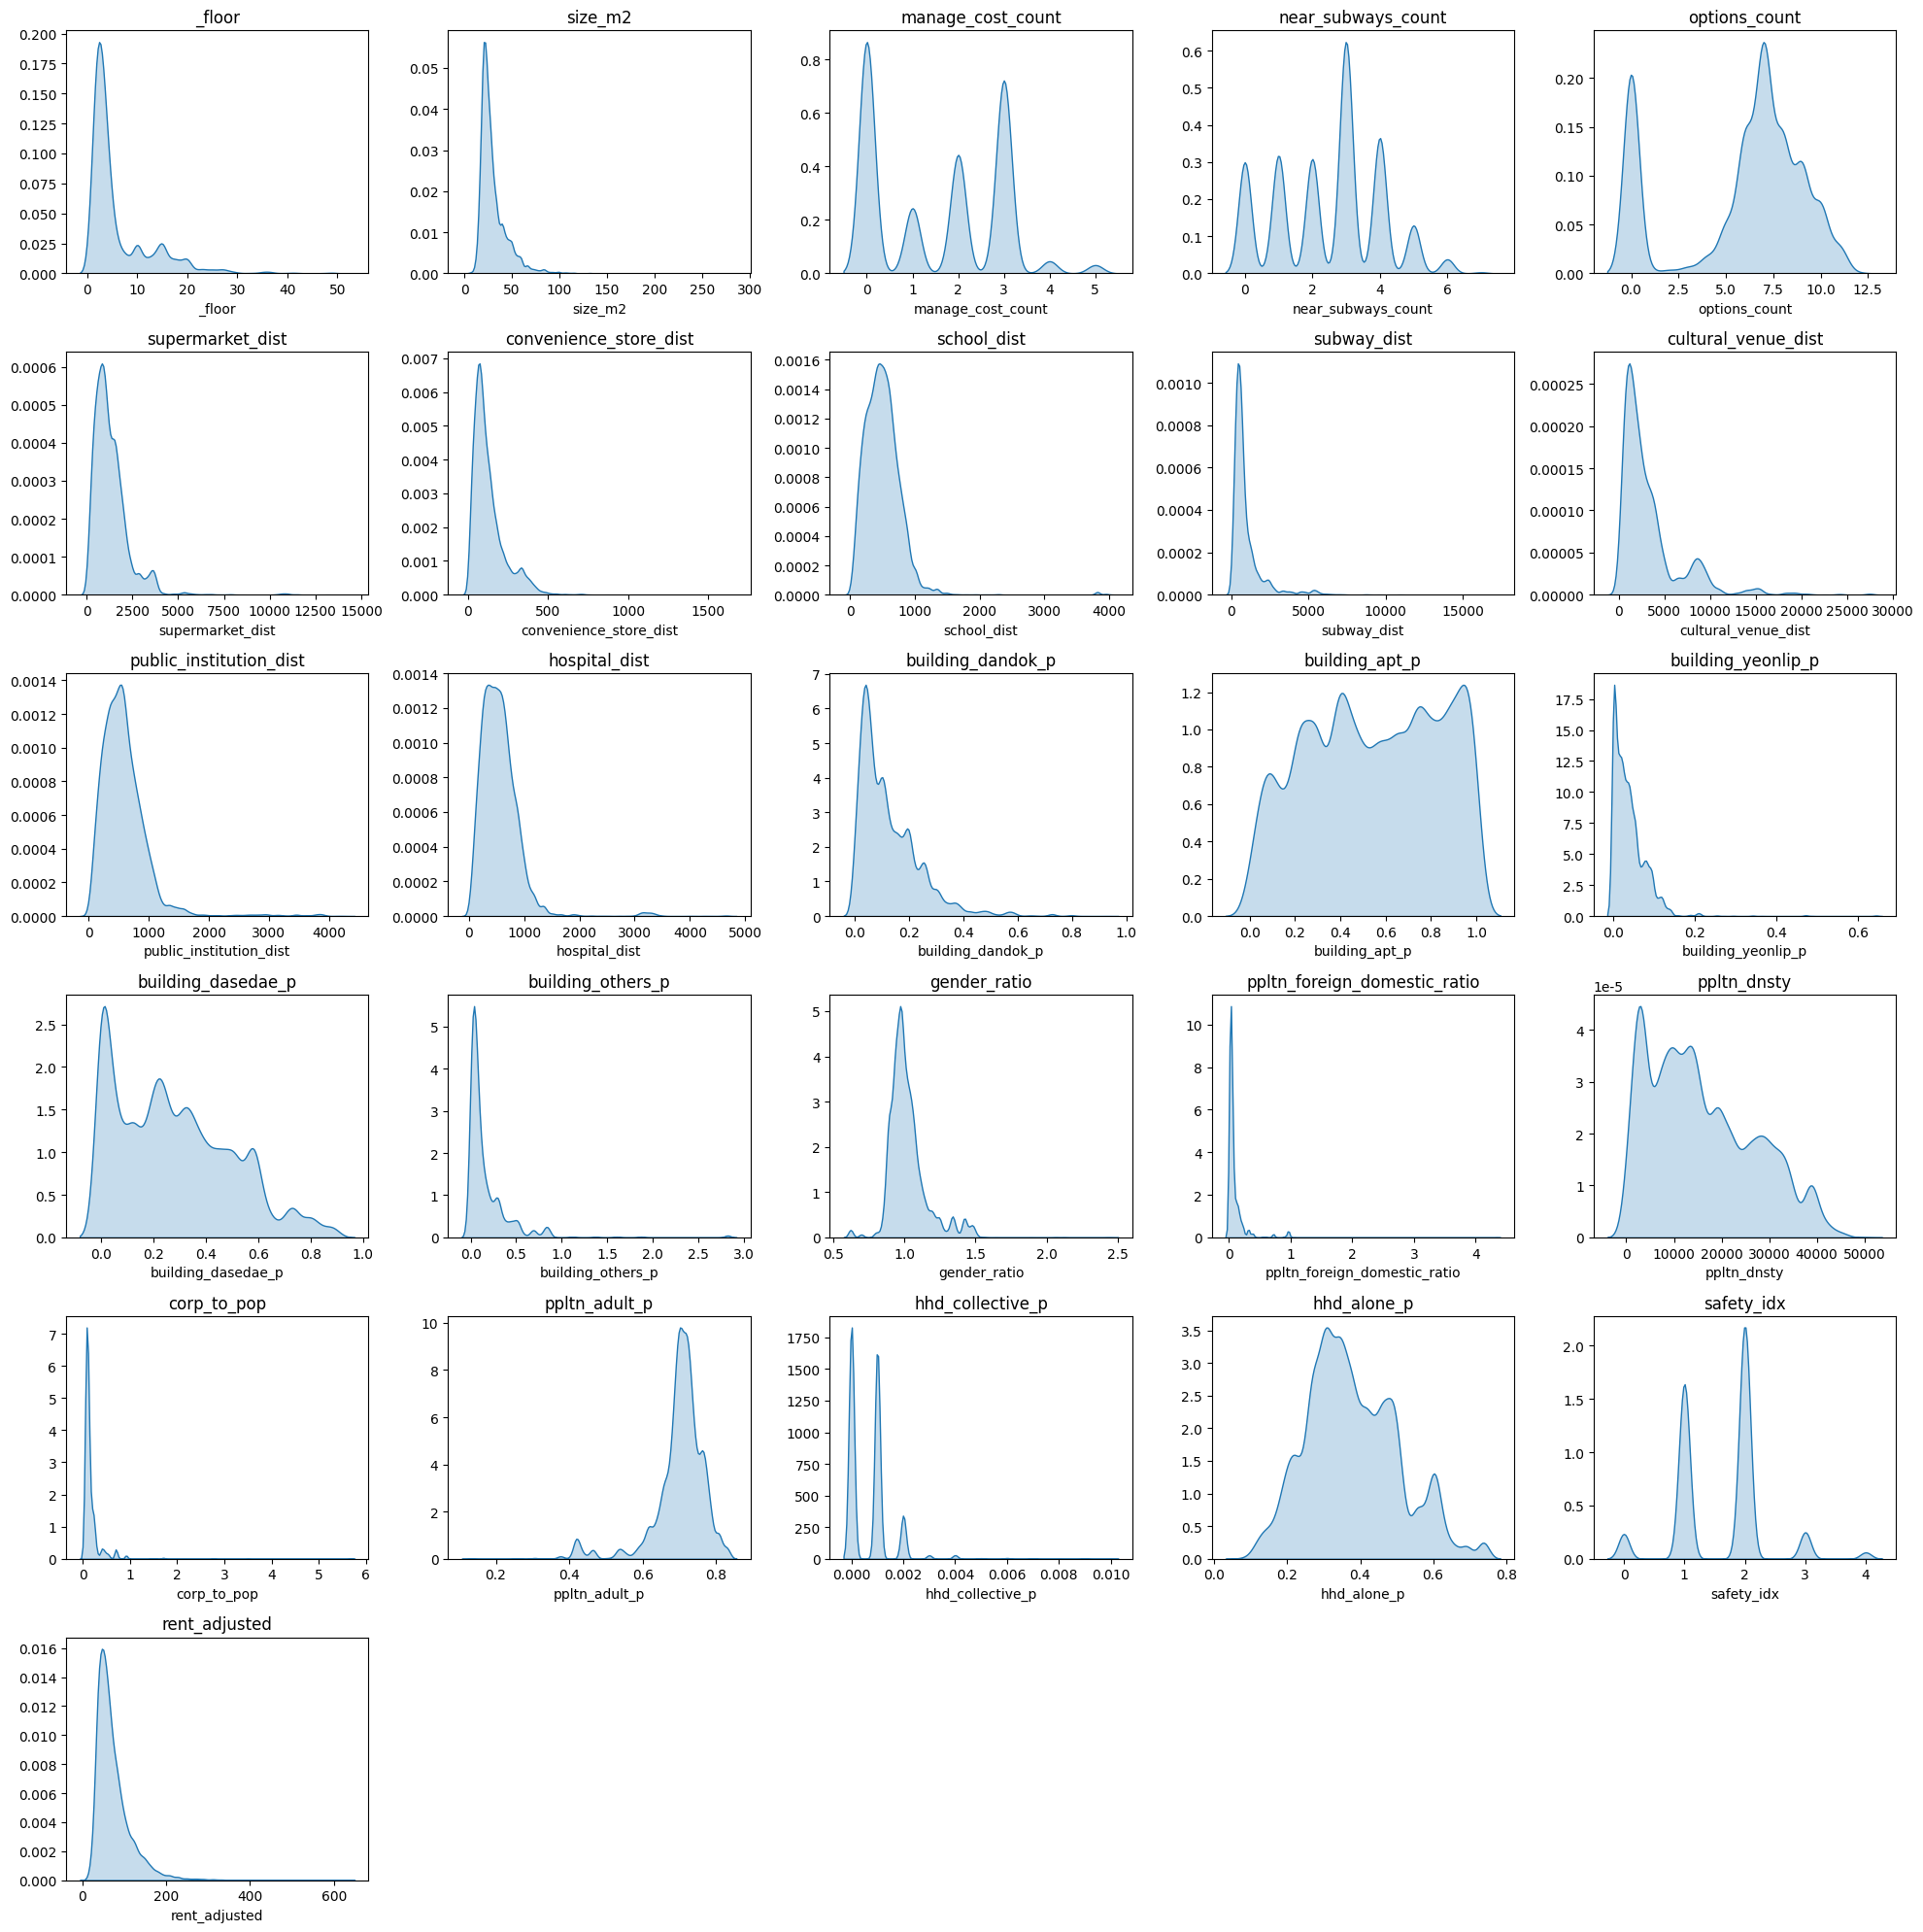

In [9]:
fig, ax = plt.subplots(6, 5, figsize=(20, 20))
ax = ax.ravel()

for i, col in enumerate(non_binary_df.columns):
    sns.kdeplot(non_binary_df[col], ax=ax[i], fill=True)  
    ax[i].set_title(col)
    ax[i].set_ylabel('')

for j in range(26, 30):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

In [10]:
from scipy.stats import normaltest

results = {}

for col in non_binary_df.columns:
    stat, p = normaltest(non_binary_df[col])
    results[col] = p

for column, p_value in results.items():
    if p_value > 0.05:
        print(f"{column} seems to follow a Gaussian distribution (p={p_value:.5f})")
    else:
        print(f"{column} does not seem to follow a Gaussian distribution (p={p_value:.5f})")

_floor does not seem to follow a Gaussian distribution (p=0.00000)
size_m2 does not seem to follow a Gaussian distribution (p=0.00000)
manage_cost_count does not seem to follow a Gaussian distribution (p=0.00000)
near_subways_count does not seem to follow a Gaussian distribution (p=0.00000)
options_count does not seem to follow a Gaussian distribution (p=0.00000)
supermarket_dist does not seem to follow a Gaussian distribution (p=0.00000)
convenience_store_dist does not seem to follow a Gaussian distribution (p=0.00000)
school_dist does not seem to follow a Gaussian distribution (p=0.00000)
subway_dist does not seem to follow a Gaussian distribution (p=0.00000)
cultural_venue_dist does not seem to follow a Gaussian distribution (p=0.00000)
public_institution_dist does not seem to follow a Gaussian distribution (p=0.00000)
hospital_dist does not seem to follow a Gaussian distribution (p=0.00000)
building_dandok_p does not seem to follow a Gaussian distribution (p=0.00000)
building_apt_p

### 박스플롯 확인 
- 데이터셋에 이상치가 너무 많다는 걸 확인할 수 있다 

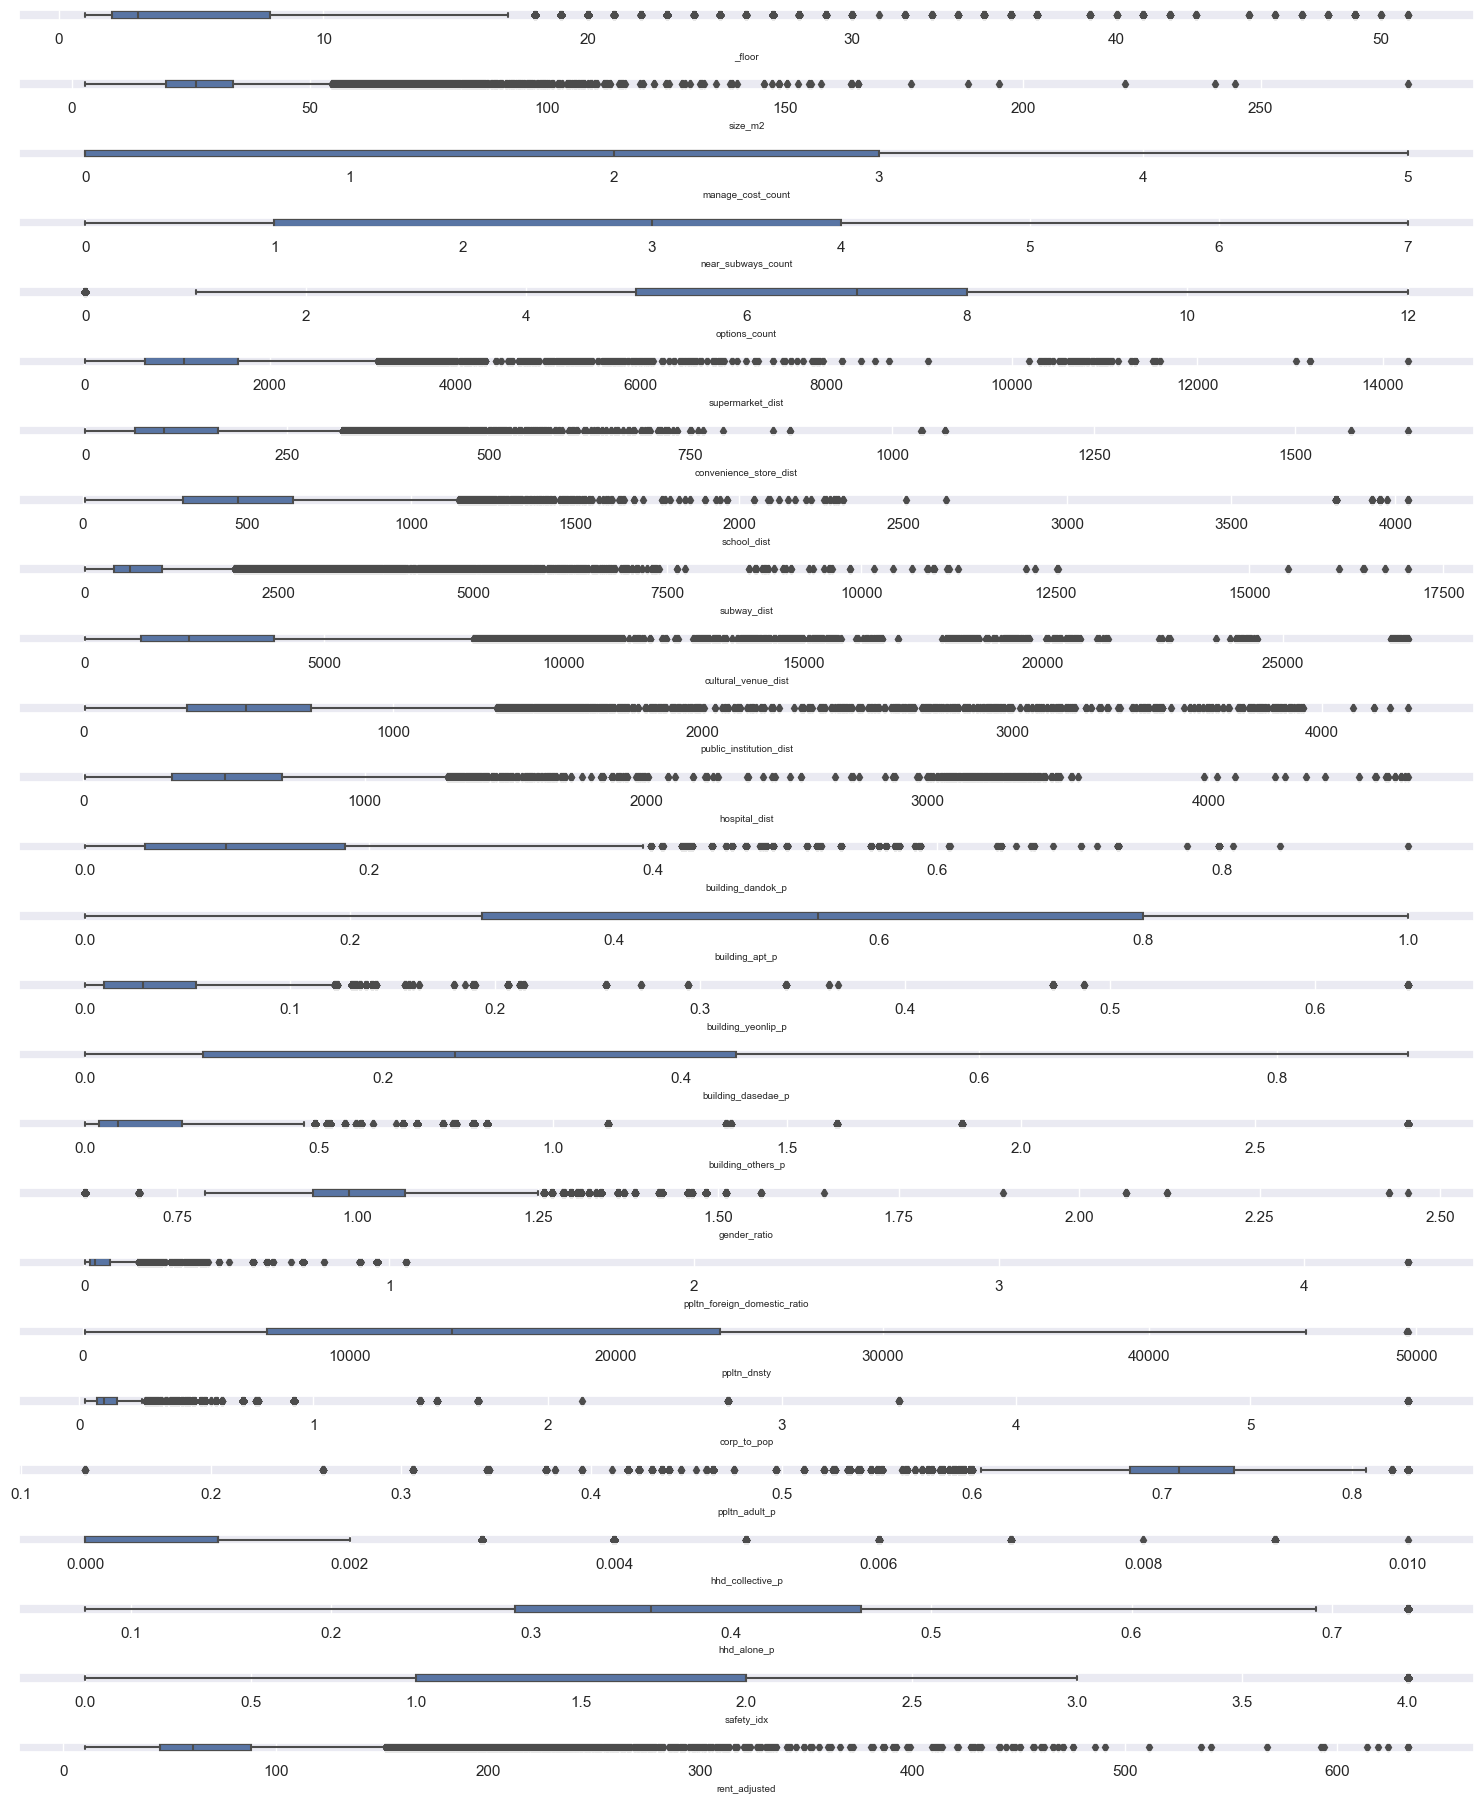

In [39]:
n = len(non_binary_df.columns)

plt.figure(figsize=(15, 0.7  * n))  

for i, col in enumerate(non_binary_df.columns, 1):
    ax = plt.subplot(n, 1, i)  
    sns.boxplot(x=non_binary_df[col])
    ax.set_xlabel(col, fontsize=7) 

plt.tight_layout()
plt.show()

## 스케일링 결론 
1. 데이터가 정규분포를 따르지 않는다 
   - Standard Scaling 적합하지 않다 
2. 이상치의 존재 
   - 대이터 내에서 이상치의 수가 많이 관찰됨 
   - 이러한 특성 때문에 MinMax Scaling은 이상치에 크게 영향을 받을 수 있으므로 적합하지 않다 

로버스트 스케일링
- 이상치의 영향을 크게 받지 않기 위해 설계되었다 
  - 중앙값과 사분위수 범위(IQR)를 활용하여 데이터를 스케일링
  - 따라서 이상치의 영향을 상대적으로 덜 받게 된다 

<b>종합적으로 로버스트 스케일링이 해당 데이터에 가장 적합하다는 결론을 내림</b>

# 요기까지

# 0909

### Clustering Method

1. hierarchical clustering (중첩 허용)거리측정 방식(L1 norm, L2 norm, mahalanobis, corr distance 등) + 군집과 군집 사이 거리(single, complete, average, centroid, ward)
    - bottom up ex) AgglomerativeClustering -> proximity matrix에서 점점 군집의 크기를 키워나감
    - top down
    - GMM (doesn't follow Gaussian Distribution so do not use)
2. partitional clustering (중첩 비허용)
    - 거리 기반 ex) KMeans (결정해야 하는 것 : K + 초기 centroid의 위치)
    - 밀도 기반 ex) DBSCAN (결정해야 하는 것 : eps + minpts)


### 평가 지표 

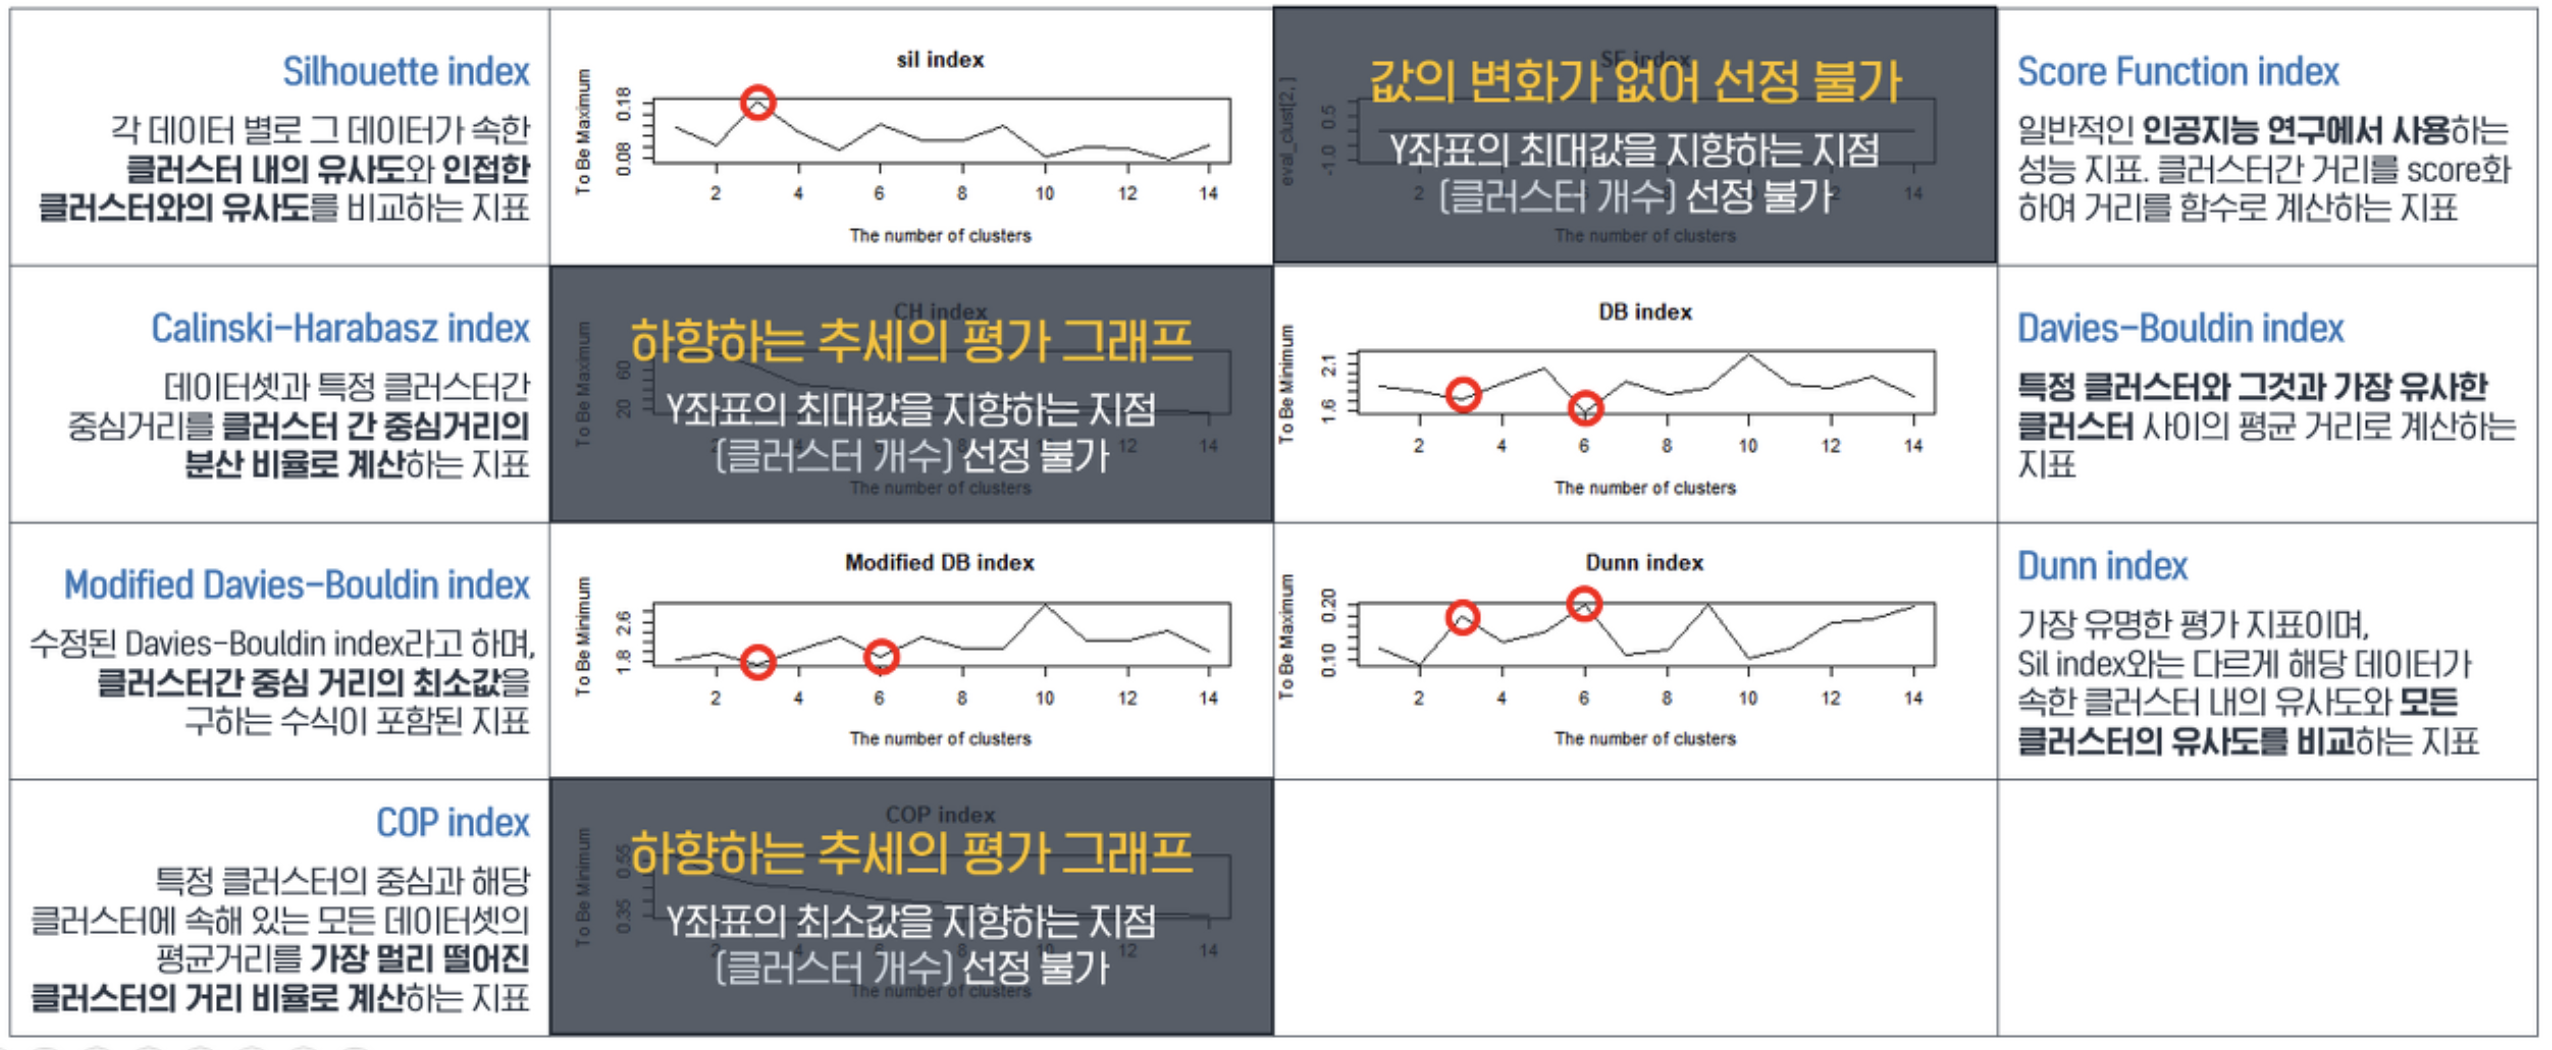

### Robust scale non-binary features while keeping binary features as they are

In [7]:
from sklearn.preprocessing import RobustScaler

binary_features = clustering_df.columns[clustering_df.nunique() == 2]
non_binary_features = clustering_df.columns.difference(binary_features)

scaler = RobustScaler()
scaled_features = scaler.fit_transform(clustering_df[non_binary_features])
scaled_df = pd.DataFrame(scaled_features, columns=non_binary_features, index=clustering_df.index)

df = pd.concat([scaled_df, clustering_df[binary_features]], axis=1)

## Number of components

## Scree Plot 
- Cumulative Explained Variance 0.8: n_components=9

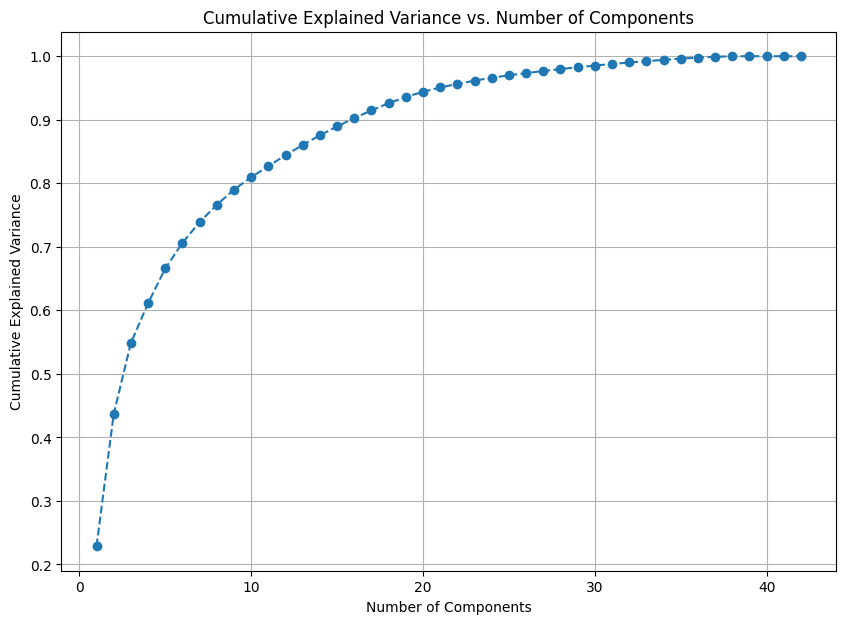

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA().fit(df)

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [9]:
n_components = 12  # Change this value based on your observations from the scree plot
pca = PCA(n_components=n_components)
pca.fit(df)

for i, component in enumerate(pca.components_):
    sorted_idx = np.argsort(component)[::-1]  # Sorted indices
    top_features_idx = sorted_idx[:10]  # Get indices of top 10 features
    top_features = [df.columns[j] for j in top_features_idx]
    top_features_weights = component[top_features_idx]
    
    features_string = ", ".join([f"{feature}: {weight:.2f}" for feature, weight in zip(top_features, top_features_weights)])
    
    print(f"Principal Component {i + 1}:")
    print(f"Features: \n{features_string}")
    print("----------------------------------------------------------")


Principal Component 1:
Features: 
corp_to_pop: 0.93, building_others_p: 0.21, ppltn_foreign_domestic_ratio: 0.17, hhd_alone_p: 0.09, rent_adjusted: 0.09, hhd_collective_p: 0.08, safety_idx: 0.07, near_subways_count: 0.06, _floor: 0.06, options_count: 0.04
----------------------------------------------------------
Principal Component 2:
Features: 
ppltn_foreign_domestic_ratio: 0.83, gender_ratio: 0.25, subway_dist: 0.14, cultural_venue_dist: 0.12, building_dandok_p: 0.09, hospital_dist: 0.08, public_institution_dist: 0.07, convenience_store_dist: 0.06, supermarket_dist: 0.05, hhd_collective_p: 0.05
----------------------------------------------------------
Principal Component 3:
Features: 
ppltn_foreign_domestic_ratio: 0.28, ppltn_dnsty: 0.14, near_subways_count: 0.14, building_others_p: 0.12, hhd_alone_p: 0.10, building_dasedae_p: 0.09, building_dandok_p: 0.05, building_yeonlip_p: 0.04, options_count: 0.03, aging_society: 0.02
----------------------------------------------------------


### n_components = 8 선정 

## Number of Clusters

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform

In [11]:
pca = PCA(n_components=9)
df_pca = pca.fit_transform(df)

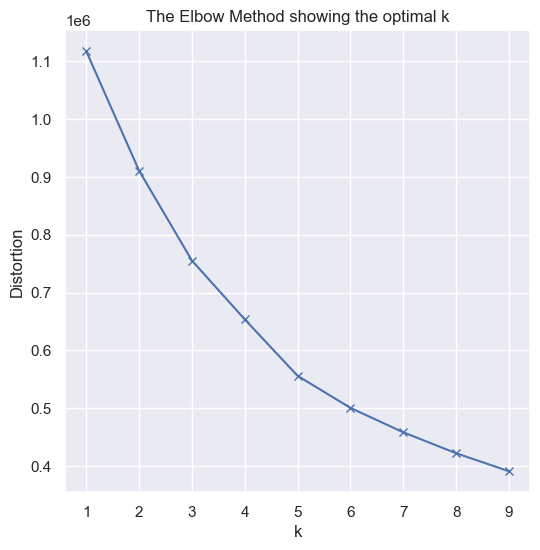

In [18]:
from sklearn.cluster import KMeans

distortions = []
K_range = range(1, 10)
for i in K_range:
    kmeanModel = KMeans(n_clusters=i)
    kmeanModel.fit(df_pca)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(6,6))
plt.plot(K_range, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.49024874503244237
For n_clusters = 3 The average silhouette_score is : 0.523987419939248
For n_clusters = 4 The average silhouette_score is : 0.45132889405388515
For n_clusters = 5 The average silhouette_score is : 0.4243018930187055
For n_clusters = 6 The average silhouette_score is : 0.386599702039745
For n_clusters = 7 The average silhouette_score is : 0.1929694713349531
For n_clusters = 8 The average silhouette_score is : 0.21321872201748726
For n_clusters = 9 The average silhouette_score is : 0.21503290757745758
For n_clusters = 10 The average silhouette_score is : 0.2059113044200981


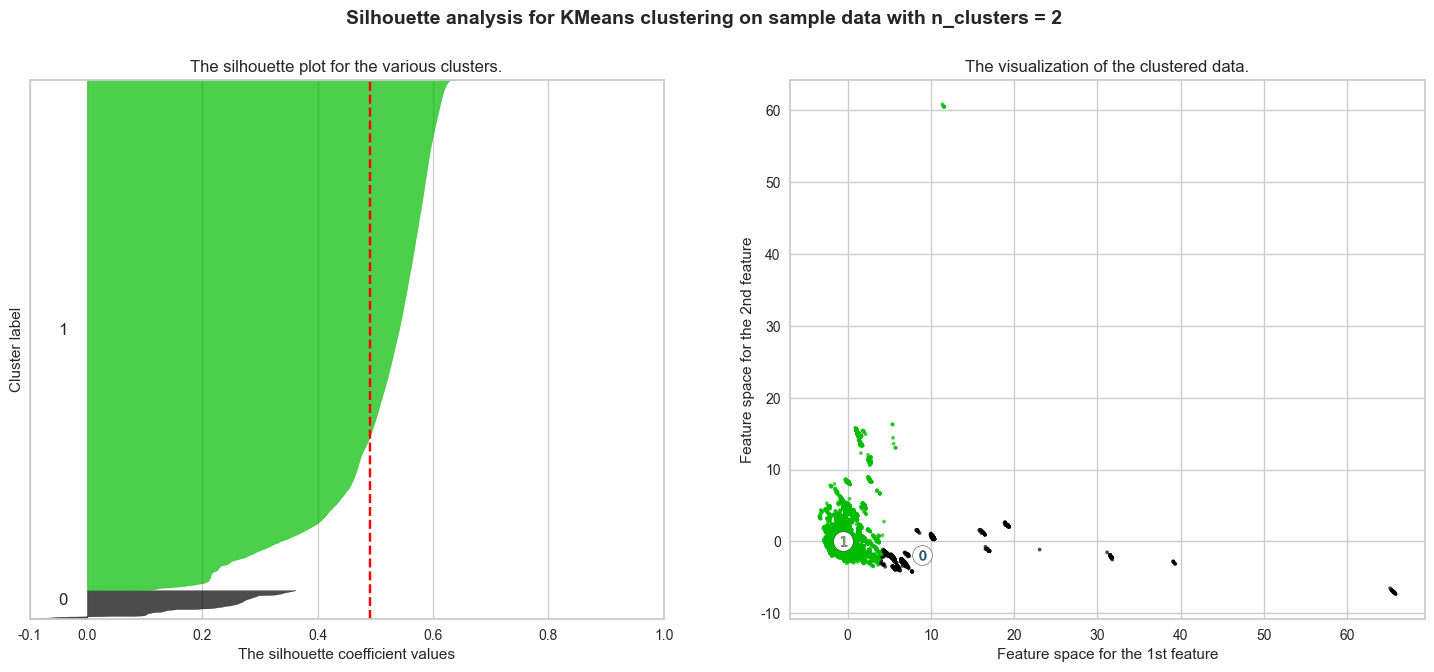

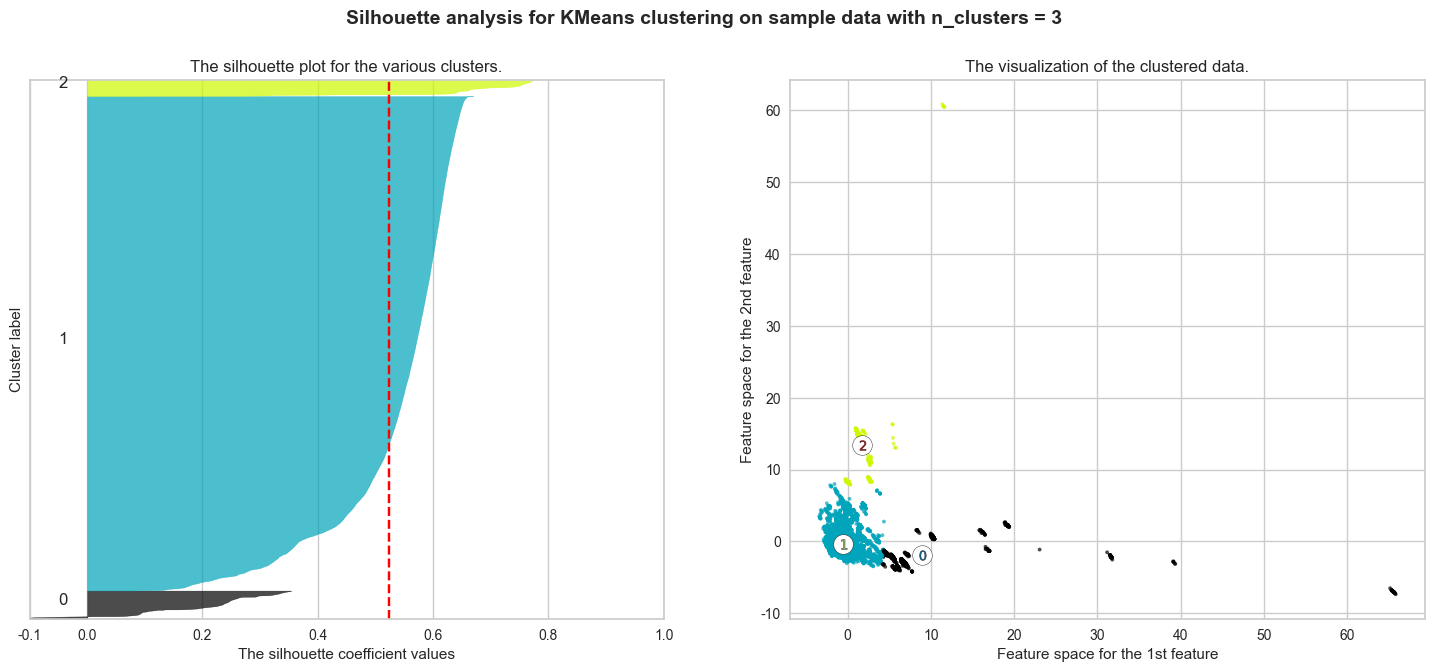

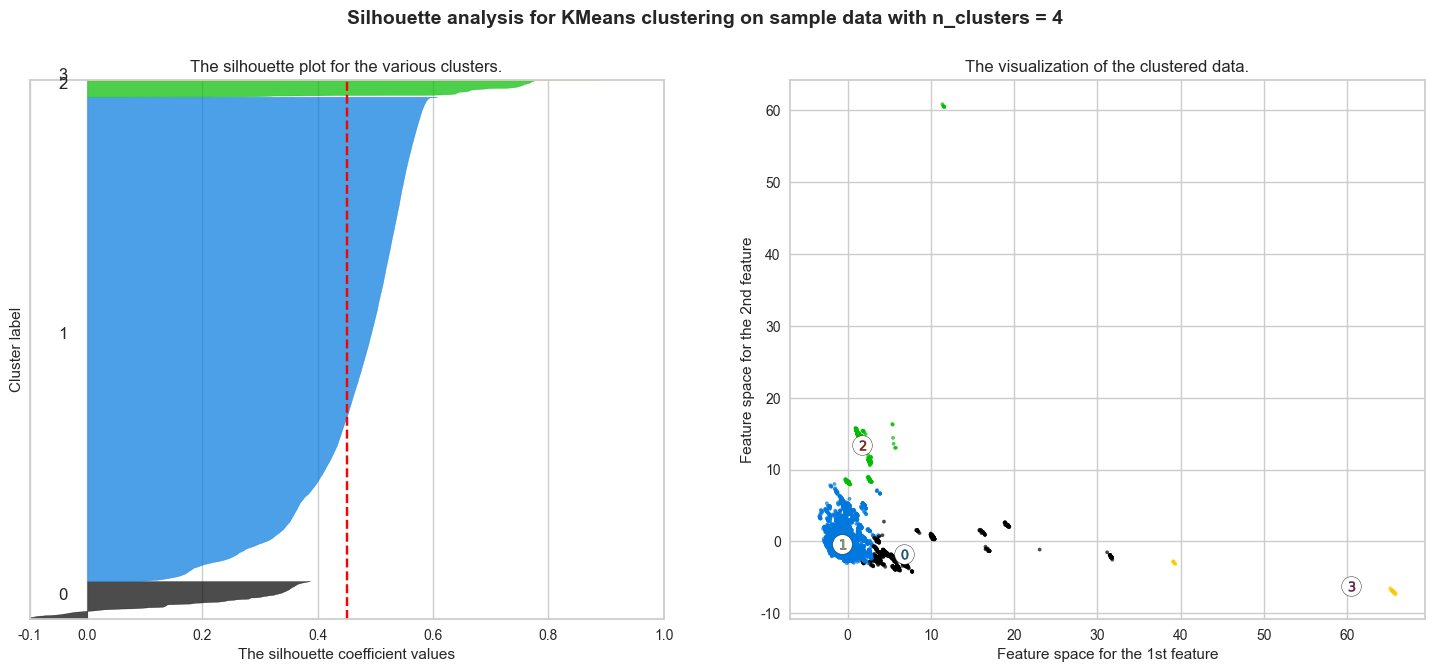

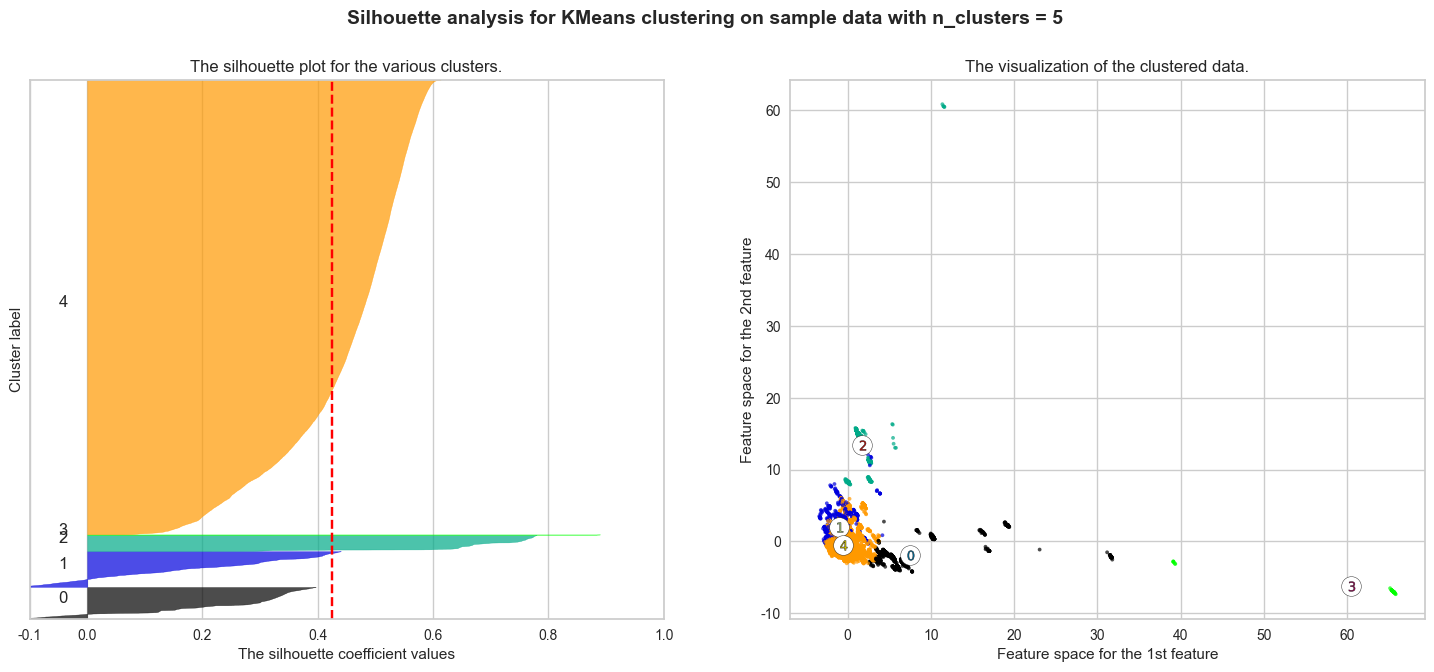

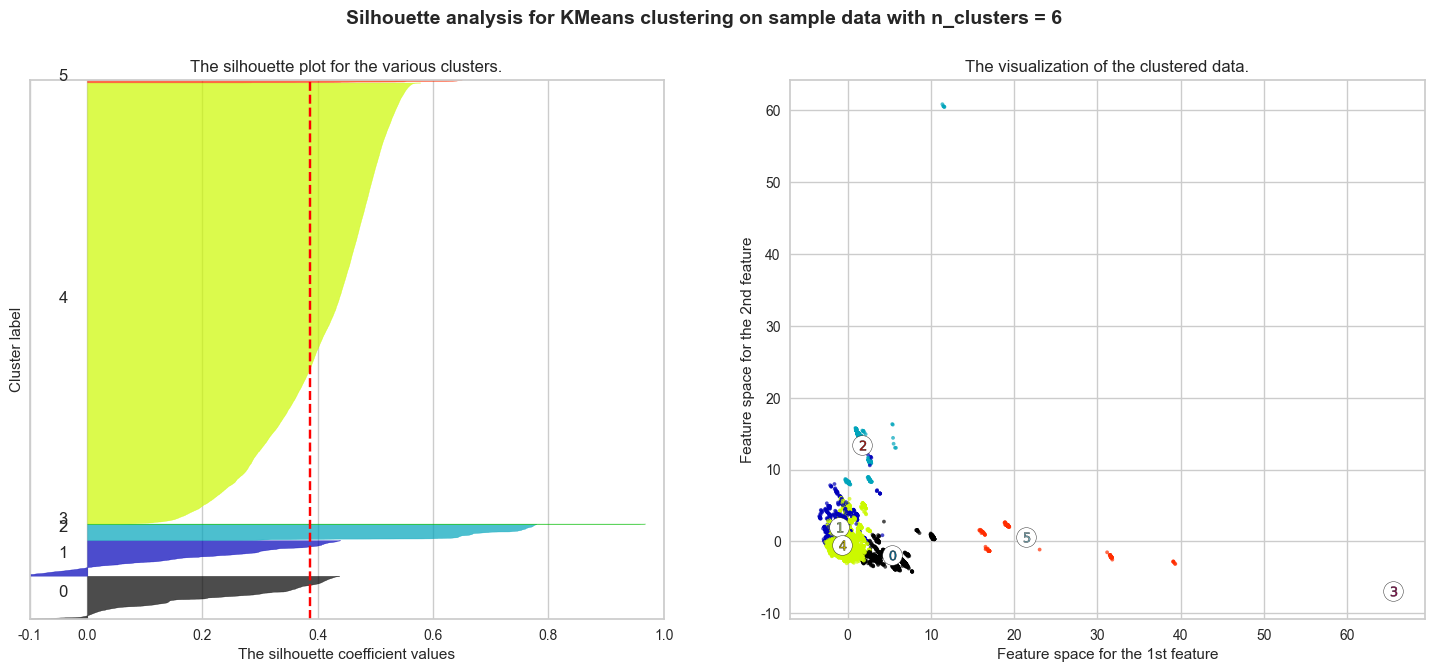

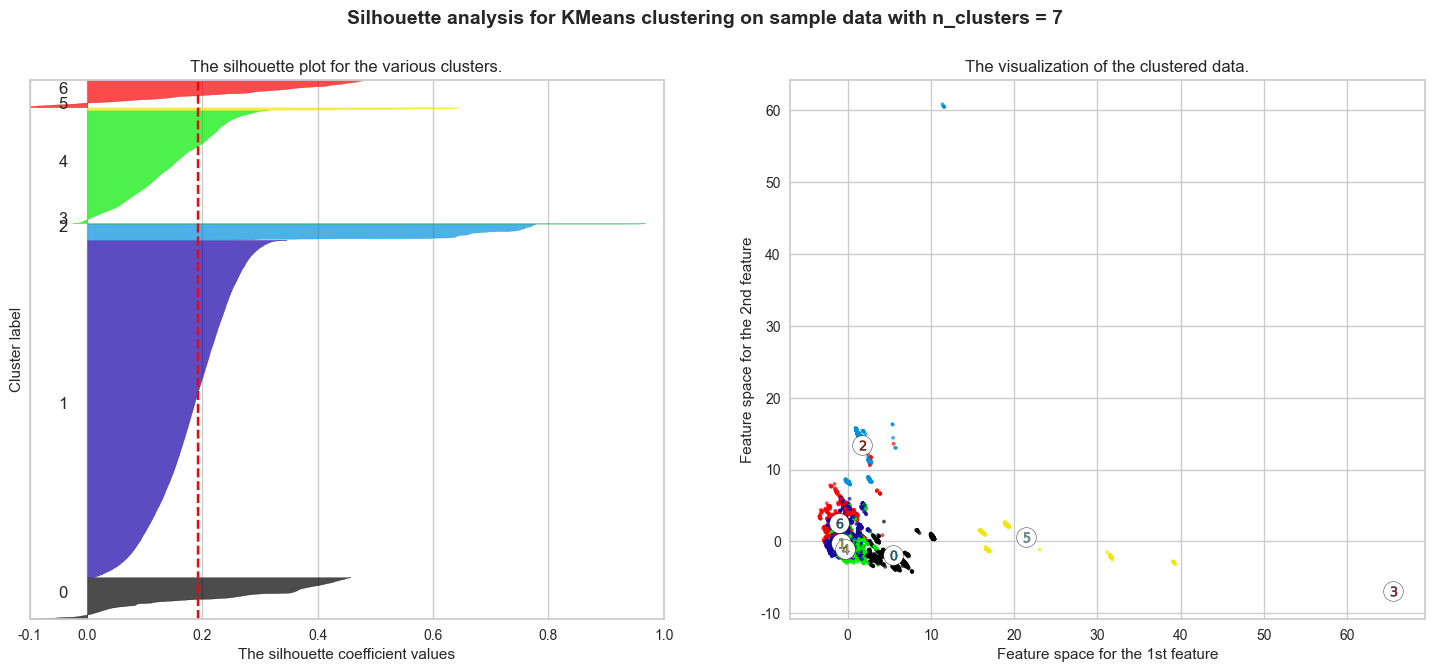

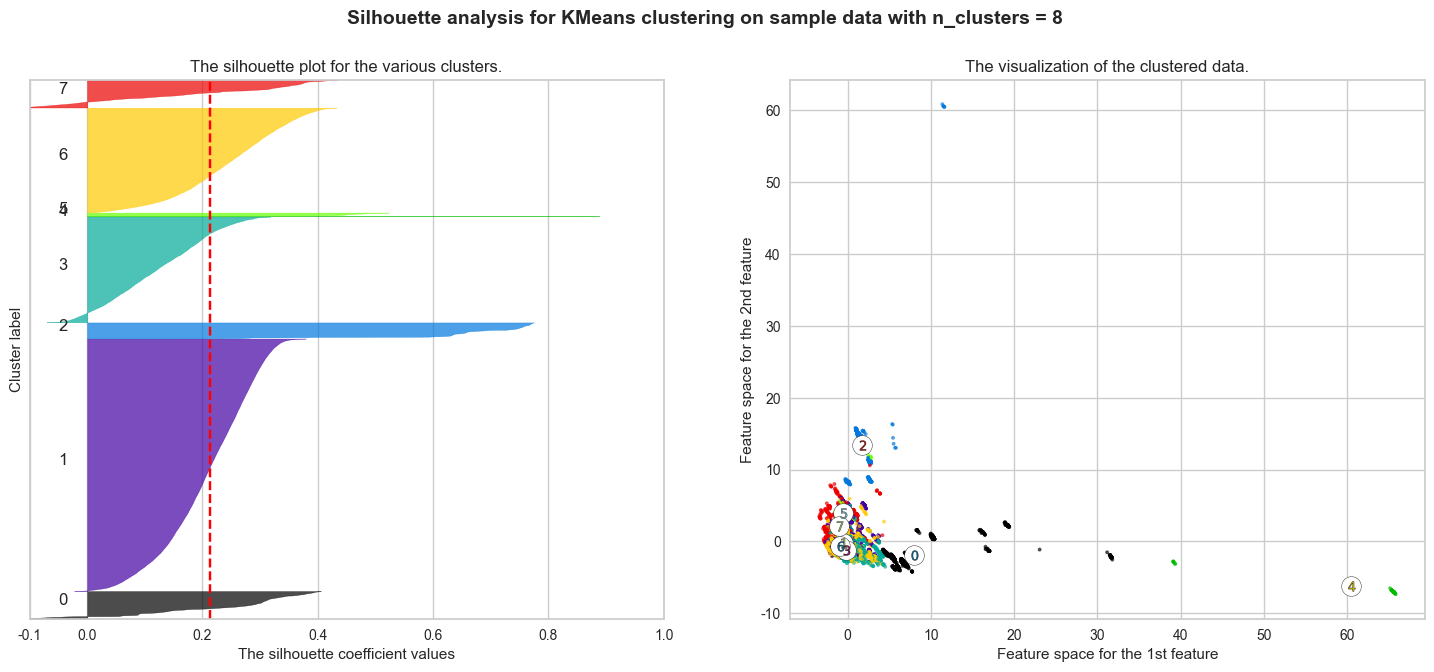

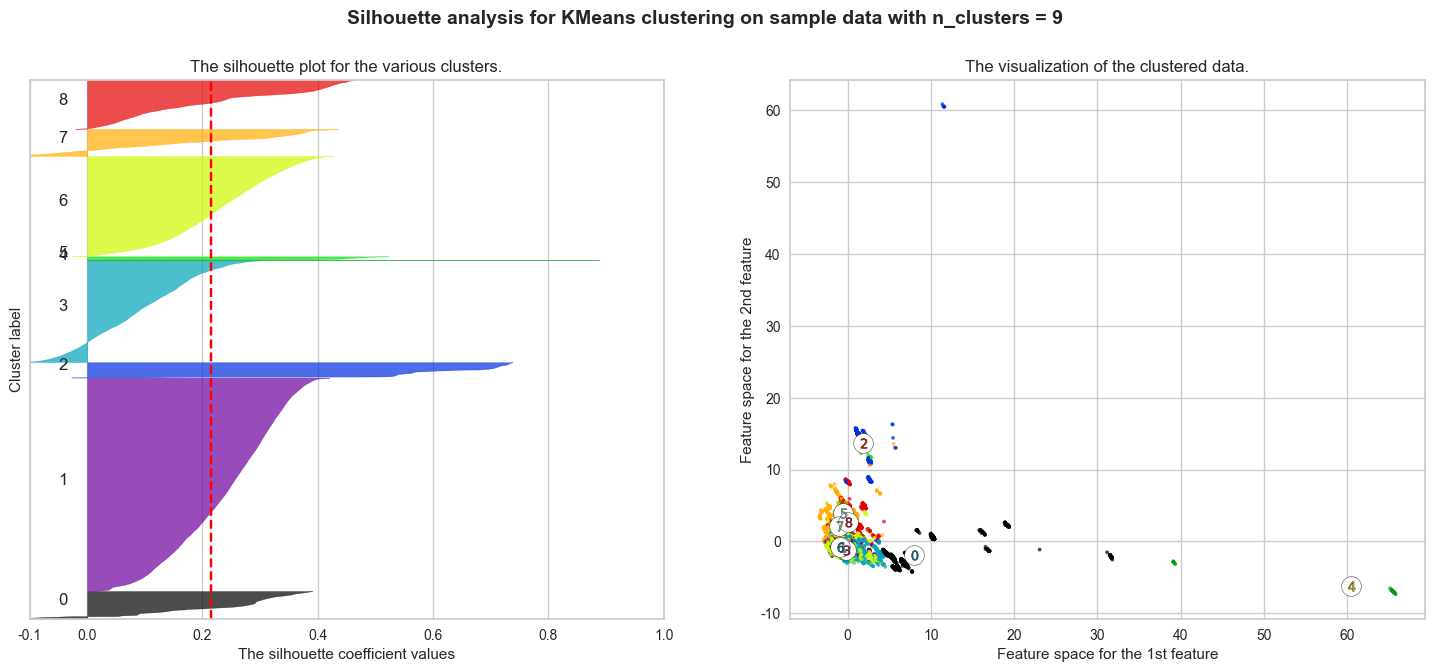

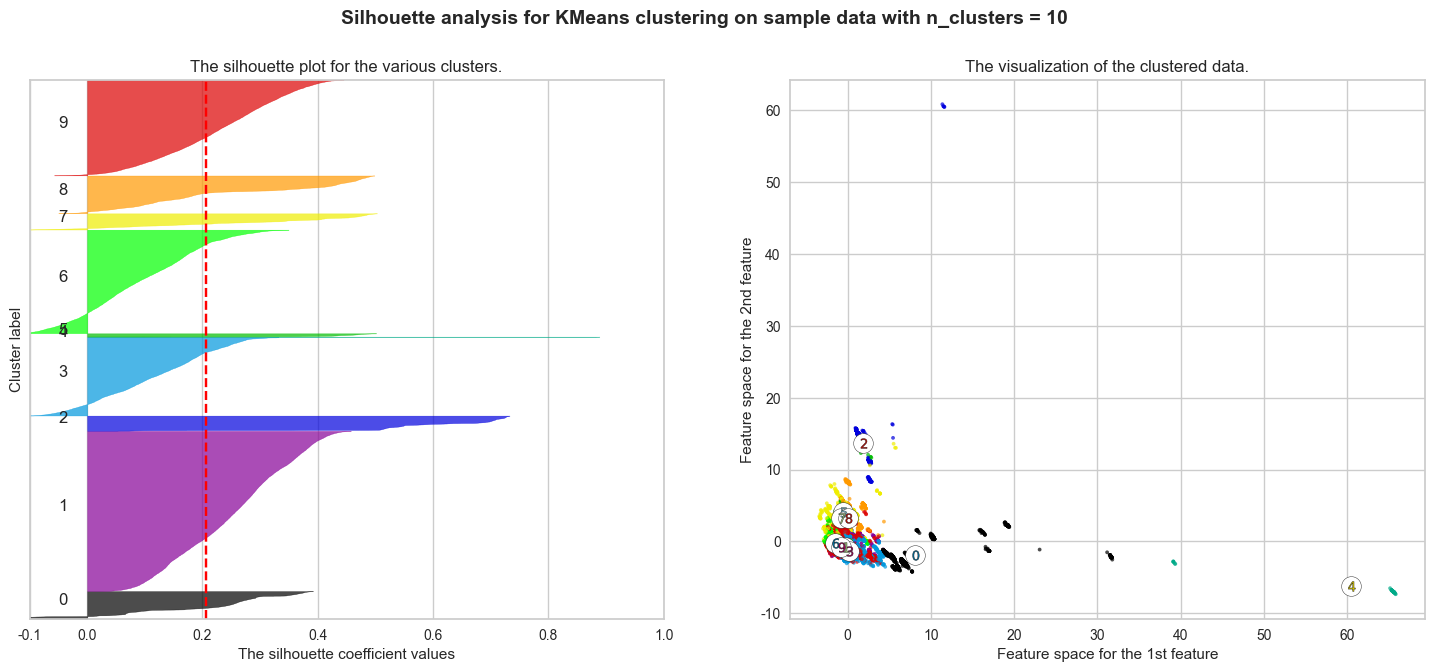

In [27]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

X = df_pca.copy() 

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


In [82]:
from sklearn.cluster import KMeans

# Assume df is your original dataframe

# Initialize KMeans
kmeans = KMeans(n_clusters=9, random_state=42)

# Fit KMeans to the data
kmeans_labels = kmeans.fit_predict(df)

# Create a copy of df and add the KMeans labels as a new column called 'cluster'
kmeans_df = df.copy()
kmeans_df['cluster'] = kmeans_labels

kmeans_df['cluster'].value_counts()

5    21832
1     7173
0     2103
2     2045
3     1017
4       59
Name: cluster, dtype: int64

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import entropy
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

fig = plt.figure(figsize=(5, 5))

components = 8
clusters = 9
df_name = '?' 

pca = PCA(n_components=components)
data_pca = pca.fit_transform(df)

kmeans = KMeans(n_clusters=clusters, max_iter=300, random_state=42)
cluster_labels = kmeans.fit_predict(data_pca)

silhouette_avg = silhouette_score(data_pca, cluster_labels)
calinski_harabasz_avg = calinski_harabasz_score(data_pca, cluster_labels)

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=cluster_labels)

ax.set_title(f'K-Means: {df_name}, {clusters} Clusters' +
             f'\nSilhouette Score: {silhouette_avg:.2f}' +
             f'\nCalinski Harabasz Score: {calinski_harabasz_avg:.2f}') 

plt.tight_layout()
plt.show()

In [88]:
import plotly.express as px
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score

components = 8
clusters = 9
df_name = '?'

pca = PCA(n_components=components)
data_pca = pca.fit_transform(df)

kmeans = KMeans(n_clusters=clusters, max_iter=300, random_state=42)
cluster_labels = kmeans.fit_predict(data_pca)

silhouette_avg = silhouette_score(data_pca, cluster_labels)
calinski_harabasz_avg = calinski_harabasz_score(data_pca, cluster_labels)

# Convert the NumPy arrays to a DataFrame for easy visualization with Plotly
df_pca = pd.DataFrame(data_pca, columns=[f"PC{i+1}" for i in range(components)])
df_pca['Cluster'] = cluster_labels

fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color='Cluster', 
                    title=f'K-Means: {df_name}, {clusters} Clusters' +
                          f'\nSilhouette Score: {silhouette_avg:.2f}' +
                          f'\nCalinski Harabasz Score: {calinski_harabasz_avg:.2f}')

fig.show()


## 함수 필요한 것들: 
- 군집 중심점 
- 피쳐/군집별로 바 그래프 시각화 (clustering_models.py)
- 분포 확인 